[OK] modelling on installation data — 2017 — found 27 rows for 2017-02-15
[OK] modelling on installation data — 2018 — found 24 rows for 2018-02-14
[OK] modelling on the daily fitted data — 2017 — found 27 rows for 2017-02-15
[OK] modelling on the daily fitted data — 2018 — found 24 rows for 2018-02-14
[OK] modelling on installation data — 2017 — found 36 rows for 2017-03-28
[OK] modelling on installation data — 2018 — found 33 rows for 2018-03-23
[OK] modelling on the daily fitted data — 2017 — found 36 rows for 2017-03-28
[OK] modelling on the daily fitted data — 2018 — found 33 rows for 2018-03-23

Saved: C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_4_alternative.png and C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\ground_based_solar_irradiance\v_results_3_output\Figure_4_5_4_alternative.svg


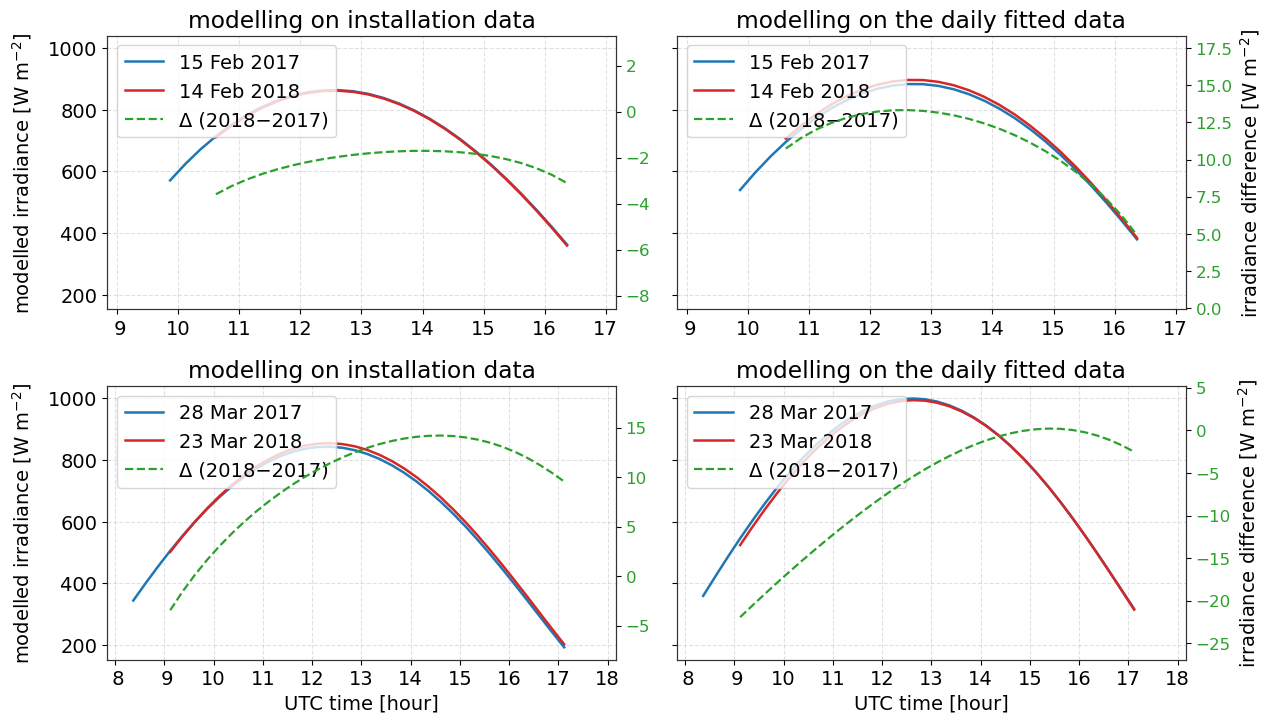

In [1]:
# -*- coding: utf-8 -*-
"""
Alternative to Figure 4.5.4 — with diagnostics for February data and right-axis label on the right subplots.

Layout (2×2):
Row 1
  Left  : modelling on installation data — 19/02/2017 vs 11/02/2018
  Right : modelling on the daily fitted data — 19/02/2017 vs 11/02/2018
Row 2
  Left  : modelling on installation data — 25/03/2017 vs 23/03/2018
  Right : modelling on the daily fitted data — 25/03/2017 vs 23/03/2018

Primary Y  : modelled POA [W/m²]
Secondary Y: Δ = (2018 − 2017), labelled only on RIGHT subplots as "irradiance difference [Wm-2]".
"""

import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- Paths ---------------------------
BASE_DIR = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/ground_based_solar_irradiance/"
INP_DIR  = os.path.join(BASE_DIR, "assets", "alignment")
OUT_DIR  = os.path.join(BASE_DIR, "v_results_3_output")
DAILY_CSV = "_daily_alignment Lazio Pyranometer 1_analysis_251029.csv"

DAILY_CSV = "_daily_alignment Bolzano_analysis_251031.csv"

FONTSIZE = 14

# If a requested day is missing, allow fallback to the closest day in the same month
ALLOW_CLOSEST_IN_MONTH = True  # set True if you want a graceful fallback

# --------------------------- Utilities ---------------------------
def _must_exist(p: Path) -> Path:
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p.resolve()}")
    return p

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

def _resolve_col(df_cols, *candidates):
    """Return the first column in df_cols that matches any candidate (case/space-insensitive)."""
    norm_map = {_norm(c): c for c in df_cols}
    for cand in candidates:
        key = _norm(cand)
        if key in norm_map:
            return norm_map[key]
    return None

def _prep_series(df: pd.DataFrame, date_col: str, hhmm_col: str, y_col: str) -> pd.DataFrame:
    """
    Standardize into ['date_dt','date','hhmm','minutes','value'] with numeric 'value' and minutes-of-day.
    """
    out = df[[date_col, hhmm_col, y_col]].copy()
    out.rename(columns={date_col: "date_str", hhmm_col: "hhmm", y_col: "value"}, inplace=True)

    # Parse date; try day-first True to accept DD/MM/YY, then fallback
    out["date_dt"] = pd.to_datetime(out["date_str"], dayfirst=True, errors="coerce")
    # fallback for ISO strings if any row failed
    mask_bad = out["date_dt"].isna()
    if mask_bad.any():
        out.loc[mask_bad, "date_dt"] = pd.to_datetime(out.loc[mask_bad, "date_str"], errors="coerce")

    out["hhmm"] = out["hhmm"].astype(str).str.slice(0, 5)  # 'HH:MM'
    hh = pd.to_datetime(out["hhmm"], format="%H:%M", errors="coerce")
    out["minutes"] = hh.dt.hour * 60 + hh.dt.minute
    out["value"]   = pd.to_numeric(out["value"], errors="coerce")

    out = out.dropna(subset=["date_dt", "hhmm", "minutes", "value"]).sort_values(["date_dt", "minutes"])
    return out

def _slice_on_date(df_std: pd.DataFrame, target_date: pd.Timestamp, label: str) -> pd.DataFrame:
    """Return rows for a specific date; if empty and fallback allowed, use closest day in same month/year."""
    sub = df_std.loc[df_std["date_dt"] == target_date].copy()       
    if not sub.empty:
        print(f"[OK] {label} — found {len(sub)} rows for {target_date.date()}")
        return sub.sort_values("minutes")

    # diagnostics if missing
    print(f"[WARN] {label} — no rows for {target_date.date()}.")
    month_rows = df_std.loc[
        (df_std["date_dt"].dt.year == target_date.year) &
        (df_std["date_dt"].dt.month == target_date.month)
    ]
    if month_rows.empty:
        print(f"       No rows at all for month {target_date.strftime('%b %Y')}. "
              f"Available unique dates (first 10): {df_std['date_dt'].dt.date.drop_duplicates().astype(str).head(10).tolist()}")
    else:
        print(f"       This month has these dates (first 10): "
              f"{month_rows['date_dt'].dt.date.drop_duplicates().astype(str).tolist()[:10]}")
    if ALLOW_CLOSEST_IN_MONTH and not month_rows.empty:
        # choose closest by |Δdays|
        dates = month_rows["date_dt"].drop_duplicates().sort_values().tolist()
        closest = min(dates, key=lambda d: abs((d - target_date).days))
        print(f"       Falling back to closest date in same month: {closest.date()}")
        return month_rows.loc[month_rows["date_dt"] == closest].sort_values("minutes")

    return pd.DataFrame(columns=["hhmm","minutes","value","date_dt"])

def _hour_ticks(mins_min: int, mins_max: int):
    """Return hourly tick positions (minutes) + labels like '8 :00' spanning the data."""
    if not np.isfinite(mins_min) or not np.isfinite(mins_max):
        return [], []
    h0 = int(np.floor(mins_min / 60.0))
    h1 = int(np.ceil (mins_max / 60.0))
    if h1 < h0: h1 = h0
    pos = [h*60 for h in range(h0, h1+1)]
    lab = [f"{h:>2d}" for h in range(h0, h1+1)]
    return pos, lab

def _difference_series(s2017: pd.DataFrame, s2018: pd.DataFrame):
    """
    Compute Δ(2018 − 2017) on common HH:MM times.
    Returns DataFrame ['hhmm','minutes','diff'].
    """
    if s2017.empty or s2018.empty:
        return pd.DataFrame(columns=["hhmm","minutes","diff"])
    left  = s2017[["hhmm","minutes","value"]].rename(columns={"value":"v17"})
    right = s2018[["hhmm","minutes","value"]].rename(columns={"value":"v18"})
    m = pd.merge(left, right[["hhmm","v18"]], on="hhmm", how="inner")
    m["diff"] = m["v18"] - m["v17"]
    return m[["hhmm","minutes","diff"]].sort_values("minutes")

# --------------------------- Load daily file ---------------------------
inp = Path(INP_DIR)
out = Path(OUT_DIR); out.mkdir(parents=True, exist_ok=True)
daily_path = _must_exist(inp / DAILY_CSV)

df = pd.read_csv(daily_path, dtype=str)

# Resolve core columns
col_date = _resolve_col(df.columns, "date", "date_fitted", "day")
if col_date is None:
    raise KeyError(f"Could not find a date column in {daily_path.name} (tried: date, date_fitted, day).")

# Installation columns (x/y)
col_hh_inst = _resolve_col(
    df.columns,
    "hour_minute_installed", "hour minute installed", "hour_minute_installation", "hour_minute_inst"
)
col_y_inst = _resolve_col(
    df.columns,
    "modelled poa (installation data) [w/m2]",
    "modelled poa (installation data) [w/m^2]",
    "poa_model_installed", "modelled_poa_installed", "poa_installed", "poa_model_installation"
)
if col_hh_inst is None or col_y_inst is None:
    raise KeyError("Missing installation columns. Expect 'hour_minute_installed' and "
                   "'modelled poa (installation data) [W/m2]' (or add aliases).")

# Daily fitted / optimal columns (x/y)
col_hh_opt = _resolve_col(
    df.columns,
    "hour_minute_fitted", "hour minute fitted", "hour_minute_optimal", "hour_minute_fit"
)
col_y_opt = _resolve_col(
    df.columns,
    "modelled poa (optimal) [w/m2]",
    "modelled poa (optimal) [w/m^2]",
    "poa_model_optimal", "modelled_poa_fitted", "poa_fitted", "poa_optimal"
)
if col_hh_opt is None or col_y_opt is None:
    raise KeyError("Missing optimal columns. Expect 'hour_minute_fitted' and "
                   "'modelled poa (optimal) [W/m2]' (or add aliases).")

# Standardize both series tables
inst_std = _prep_series(df, col_date, col_hh_inst, col_y_inst)
opt_std  = _prep_series(df, col_date, col_hh_opt,  col_y_opt)

# --------------------------- Requested date pairs ---------------------------
# Lazio
dates_pairs = [
    # Row 1 (February)
    (pd.Timestamp("2017-02-19"), pd.Timestamp("2018-02-11")),
    # Row 2 (March)
    (pd.Timestamp("2017-03-25"), pd.Timestamp("2018-03-23")),
]

# Trentino
dates_pairs = [
    # Row 1 (February)
    (pd.Timestamp("2017-02-15"), pd.Timestamp("2018-02-14")),
    # Row 2 (March)
    (pd.Timestamp("2017-03-28"), pd.Timestamp("2018-03-23")),
]


# --------------------------- Plotting ---------------------------
plt.rcParams.update({
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#bdbdbd",
    "grid.linestyle": "--",
    "grid.alpha": 0.45,
    "axes.grid": True,
    "font.size": FONTSIZE,
})

fig, axes = plt.subplots(2, 2, figsize=(12.4, 7.8), sharex=False, sharey=True)
axes = axes.reshape(2, 2)

COL_17 = "#1f77b4"
COL_18 = "#d62728"
COL_DF = "#2ca02c"
LW     = 1.8

def _plot_panel(ax, std_df, date17, date18, is_right_panel: bool, left_title: str, right_title: str):
    """Plot 2017 & 2018 on primary axis; Δ on twin axis; apply titles and axis labels."""
    # Slice (with diagnostics + optional closest-in-month fallback)
    s17 = _slice_on_date(std_df, date17, f"{left_title if not is_right_panel else right_title} — 2017")
    s18 = _slice_on_date(std_df, date18, f"{left_title if not is_right_panel else right_title} — 2018")

    # Main curves
    if not s17.empty:
        ax.plot(s17["minutes"], s17["value"], color=COL_17, linewidth=LW, label=date17.strftime("%d %b %Y"))
    if not s18.empty:
        ax.plot(s18["minutes"], s18["value"], color=COL_18, linewidth=LW, label=date18.strftime("%d %b %Y"))

    # X ticks: hourly
    mins_all = pd.concat([s17["minutes"], s18["minutes"]], axis=0).dropna()
    if not mins_all.empty:
        xmin, xmax = int(mins_all.min()), int(mins_all.max())
        ticks, labs = _hour_ticks(xmin, xmax)
        if ticks:
            ax.set_xticks(ticks); ax.set_xticklabels(labs)
            ax.set_xlim(ticks[0]-10, ticks[-1]+10)

    # Secondary Δ (2018-2017) on twin axis
    ax2 = ax.twinx()
    ddf = _difference_series(s17, s18)
    if not ddf.empty:
        ax2.plot(ddf["minutes"], ddf["diff"], color=COL_DF, linewidth=LW-0.2, linestyle="--",
                 label="Δ (2018−2017)")
        # Centered-ish limits
        dmin, dmax = float(ddf["diff"].min()), float(ddf["diff"].max())
        span = dmax - dmin
        pad  = max(0.05*span, 5.0)
        ax2.set_ylim(dmin - pad, dmax + pad)
        # 31/10/25 adding -1 since still too big
        ax2.tick_params(axis="y", labelcolor=COL_DF, labelsize=max(FONTSIZE-1-1, 8))
    ax2.grid(False)

    # Titles per your spec
    ax.set_title(right_title if is_right_panel else left_title)

    # Y2 label only on RIGHT panels
    if is_right_panel:
        ax2.set_ylabel("irradiance difference [W m$^{-2}$]", fontsize=FONTSIZE)

    # Compact legend (merge primary + secondary)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    if h1 or h2:
        ax.legend(h1+h2, l1+l2, loc="upper left", fontsize=FONTSIZE, frameon=True)

# Row 1 (February)
_plot_panel(
    axes[0, 0], inst_std,
    dates_pairs[0][0], dates_pairs[0][1],
    is_right_panel=False,
    left_title="modelling on installation data",
    right_title="modelling on the daily fitted data"
)
_plot_panel(
    axes[0, 1], opt_std,
    dates_pairs[0][0], dates_pairs[0][1],
    is_right_panel=True,
    left_title="modelling on installation data",
    right_title="modelling on the daily fitted data"
)

# Row 2 (March)
_plot_panel(
    axes[1, 0], inst_std,
    dates_pairs[1][0], dates_pairs[1][1],
    is_right_panel=False,
    left_title="modelling on installation data",
    right_title="modelling on the daily fitted data"
)
_plot_panel(
    axes[1, 1], opt_std,
    dates_pairs[1][0], dates_pairs[1][1],
    is_right_panel=True,
    left_title="modelling on installation data",
    right_title="modelling on the daily fitted data"
)

# Axis labels (left column y, bottom row x)
axes[0, 0].set_ylabel("modelled irradiance [W m$^{-2}$]", fontsize=FONTSIZE, labelpad=10)
axes[1, 0].set_ylabel("modelled irradiance [W m$^{-2}$]", fontsize=FONTSIZE, labelpad=10)
axes[1, 0].set_xlabel("UTC time [hour]", fontsize=FONTSIZE)
axes[1, 1].set_xlabel("UTC time [hour]", fontsize=FONTSIZE)

# Layout & save
fig = plt.gcf()
fig.subplots_adjust(wspace=0.12, hspace=0.28, left=0.08, right=0.95, top=0.92, bottom=0.12)
png = out / "Figure_4_5_4_alternative.png"
svg = out / "Figure_4_5_4_alternative.svg"
fig.savefig(png, dpi=300)
fig.savefig(svg)
print(f"\nSaved: {png} and {svg}")